In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt
import plotly.express as px
from scipy.stats import boxcox
import plotly.graph_objects as go
from pandas.plotting import lag_plot
import statsmodels.formula.api as smf
from plotly.subplots import make_subplots
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
uploaded = files.upload()

Saving CocaCola_Sales_Rawdata.xlsx to CocaCola_Sales_Rawdata.xlsx


In [3]:
cola = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')

In [4]:
cola.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [5]:
cola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [6]:
cola.shape

(42, 2)

In [7]:
cola.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [8]:
cola.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [9]:
# Converting quarterly periods to datetime in pandas
cola['Quarter_Year'] = cola['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))
cola.head(10)

,Quarter,Sales,Quarter_Year
0,Q1_86,1734.827000,Q1 1986
1,Q2_86,2244.960999,Q2 1986
2,Q3_86,2533.804993,Q3 1986
3,Q4_86,2154.962997,Q4 1986
4,Q1_87,1547.818996,Q1 1987
5,Q2_87,2104.411995,Q2 1987
6,Q3_87,2014.362999,Q3 1987
7,Q4_87,1991.746998,Q4 1987
8,Q1_88,1869.049999,Q1 1988
9,Q2_88,2313.631996,Q2 1988


In [10]:
# Converting into datetime formate as the index was not in correct format
cola['Date'] = (pd.to_datetime(cola['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1])),dayfirst=True))
cola.head(10)

,Quarter,Sales,Quarter_Year,Date
0,Q1_86,1734.827000,Q1 1986,1986-01-01
1,Q2_86,2244.960999,Q2 1986,1986-04-01
2,Q3_86,2533.804993,Q3 1986,1986-07-01
3,Q4_86,2154.962997,Q4 1986,1986-10-01
4,Q1_87,1547.818996,Q1 1987,1987-01-01
5,Q2_87,2104.411995,Q2 1987,1987-04-01
6,Q3_87,2014.362999,Q3 1987,1987-07-01
7,Q4_87,1991.746998,Q4 1987,1987-10-01
8,Q1_88,1869.049999,Q1 1988,1988-01-01
9,Q2_88,2313.631996,Q2 1988,1988-04-01


In [13]:
cola['Quarters'] = 0

for i in range(42):
    n = cola['Quarter'][i]
    cola['Quarters'][i] = n[0:2]

cola.head(10)

,Quarter,Sales,Quarter_Year,Date,Quarters
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1
5,Q2_87,2104.411995,Q2 1987,1987-04-01,Q2
6,Q3_87,2014.362999,Q3 1987,1987-07-01,Q3
7,Q4_87,1991.746998,Q4 1987,1987-10-01,Q4
8,Q1_88,1869.049999,Q1 1988,1988-01-01,Q1
9,Q2_88,2313.631996,Q2 1988,1988-04-01,Q2


In [14]:
dummy = pd.DataFrame(pd.get_dummies(cola['Quarters']))
cola1 = pd.concat((cola, dummy), axis=1)

cola1.head()

,Quarter,Sales,Quarter_Year,Date,Quarters,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,1,0,0,0
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,0,1,0,0
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,0,0,1,0
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,0,0,0,1
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,1,0,0,0


In [15]:
cola1.drop(['Quarter','Quarter_Year'] , axis =1, inplace = True)
cola1.head()

,Sales,Date,Quarters,Q1,Q2,Q3,Q4
0,1734.827000,1986-01-01,Q1,1,0,0,0
1,2244.960999,1986-04-01,Q2,0,1,0,0
2,2533.804993,1986-07-01,Q3,0,0,1,0
3,2154.962997,1986-10-01,Q4,0,0,0,1
4,1547.818996,1987-01-01,Q1,1,0,0,0


In [16]:
cola1.set_index('Date',inplace=True)
cola1.index.year

Int64Index([1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1988, 1988, 1988,
            1988, 1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991,
            1991, 1991, 1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994,
            1994, 1994, 1994, 1995, 1995, 1995, 1995, 1996, 1996],
           dtype='int64', name='Date')

In [17]:
cola1.head()

,Sales,Quarters,Q1,Q2,Q3,Q4
Date,,,,,,
1986-01-01,1734.827000,Q1,1,0,0,0
1986-04-01,2244.960999,Q2,0,1,0,0
1986-07-01,2533.804993,Q3,0,0,1,0
1986-10-01,2154.962997,Q4,0,0,0,1
1987-01-01,1547.818996,Q1,1,0,0,0


In [18]:
cola["Date"] = pd.to_datetime(cola.Date,format="%b-%y")
cola["month"] = cola.Date.dt.strftime("%b") # month extraction
cola["year"] = cola.Date.dt.strftime("%Y") # year extraction
cola.head(10)

,Quarter,Sales,Quarter_Year,Date,Quarters,month,year
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,Jan,1986
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,Apr,1986
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,Jul,1986
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,Oct,1986
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,Jan,1987
5,Q2_87,2104.411995,Q2 1987,1987-04-01,Q2,Apr,1987
6,Q3_87,2014.362999,Q3 1987,1987-07-01,Q3,Jul,1987
7,Q4_87,1991.746998,Q4 1987,1987-10-01,Q4,Oct,1987
8,Q1_88,1869.049999,Q1 1988,1988-01-01,Q1,Jan,1988
9,Q2_88,2313.631996,Q2 1988,1988-04-01,Q2,Apr,1988


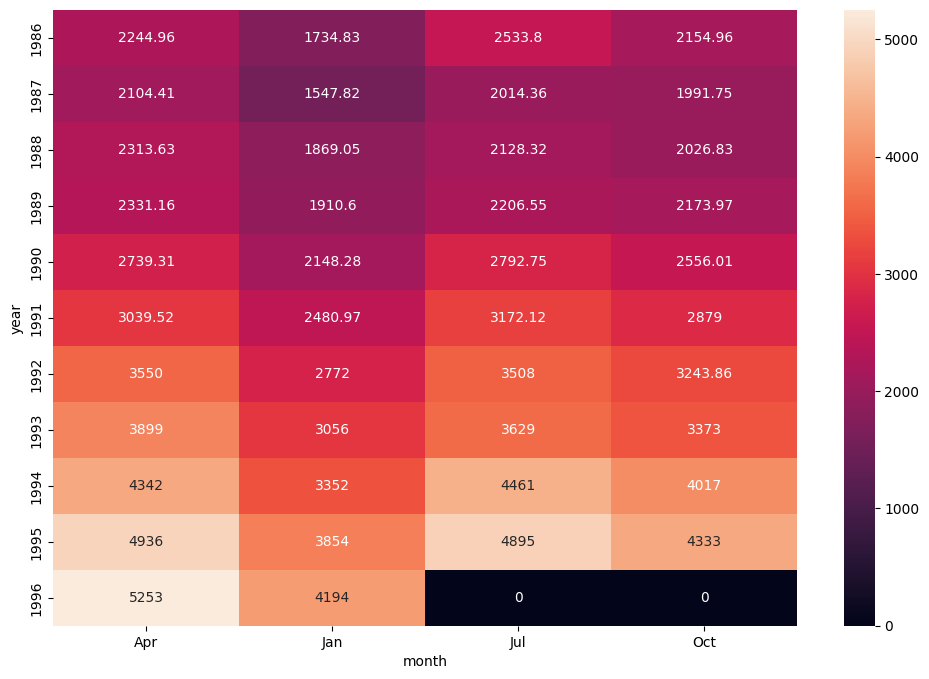

In [19]:
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data = cola, values="Sales", index="year", columns="month", aggfunc="mean", fill_value=0)
sns.heatmap(heatmap_y_month, annot=True, fmt="g")
plt.show()

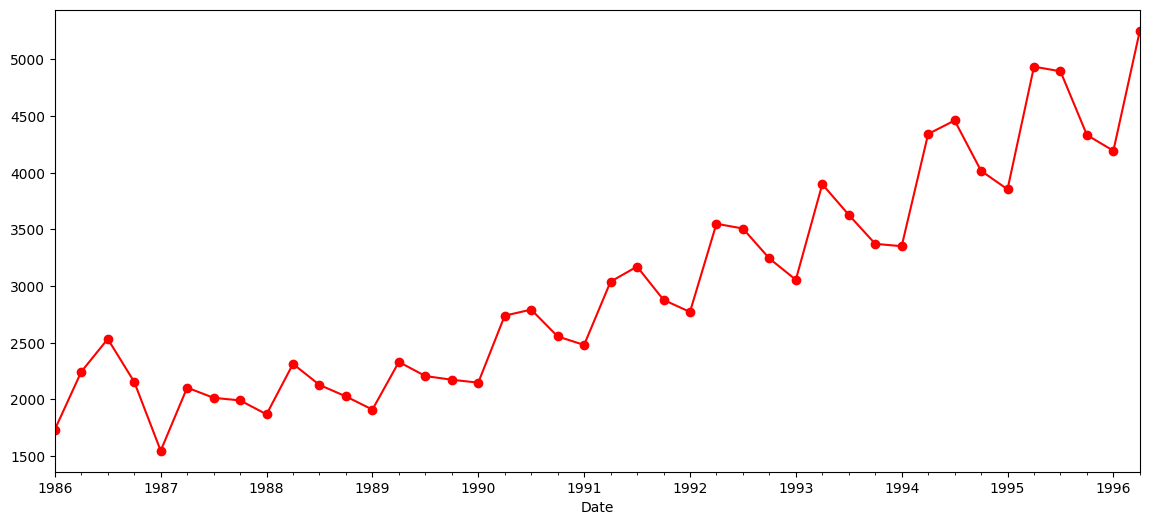

In [21]:
cola1['Sales'].plot(figsize=(14,6), color='red', marker='o')
plt.show()


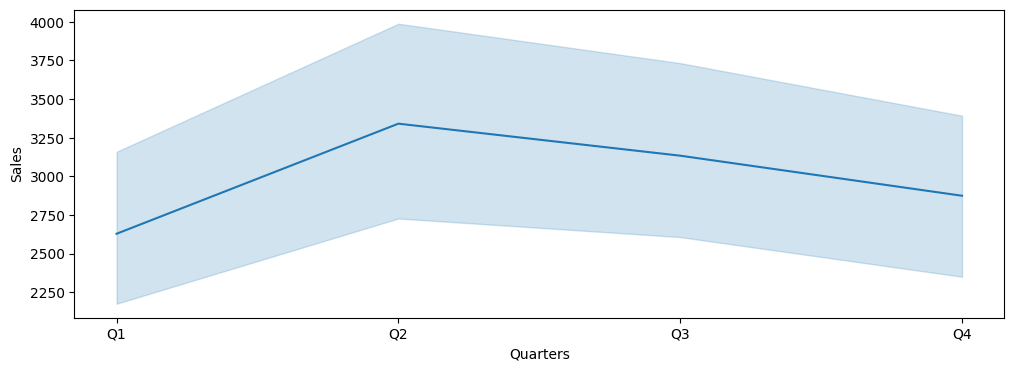

In [23]:
plt.figure(figsize=(12,4))
sns.lineplot(x="Quarters", y="Sales", data=cola)
plt.show()


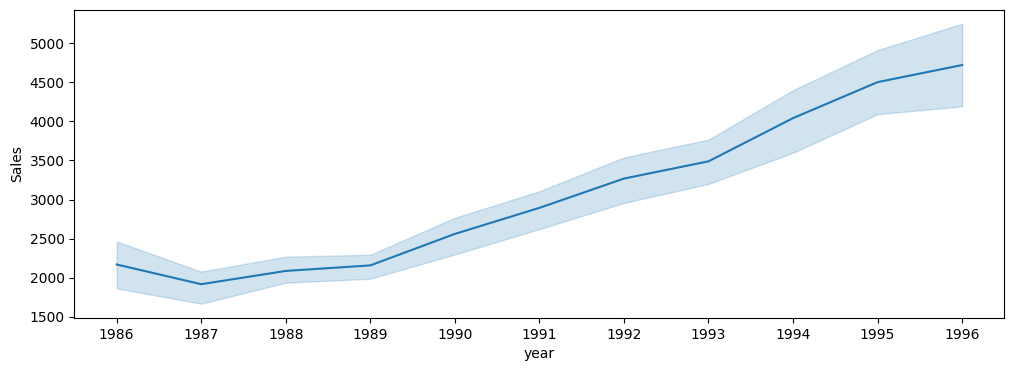

In [24]:
plt.figure(figsize=(12,4))
sns.lineplot(x="year", y="Sales", data=cola)
plt.show()


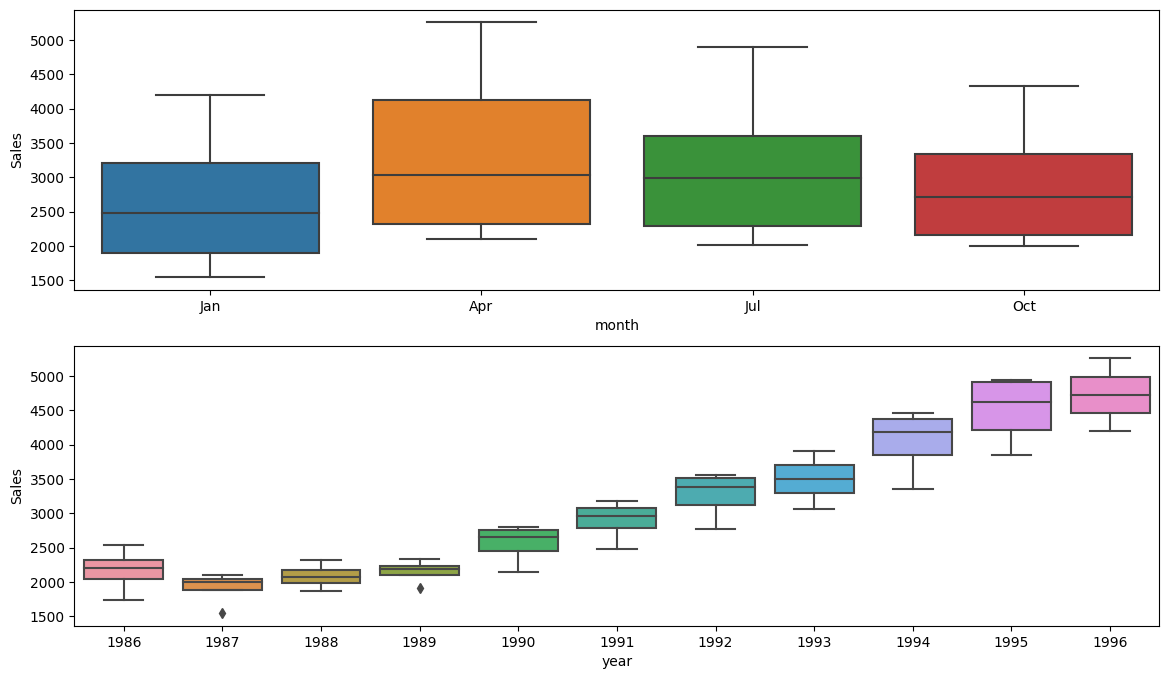

In [25]:
plt.figure(figsize=(14,8))
plt.subplot(211)
sns.boxplot(x="month",y="Sales",data=cola)
plt.subplot(212)
sns.boxplot(x="year",y="Sales",data=cola)
plt.show()

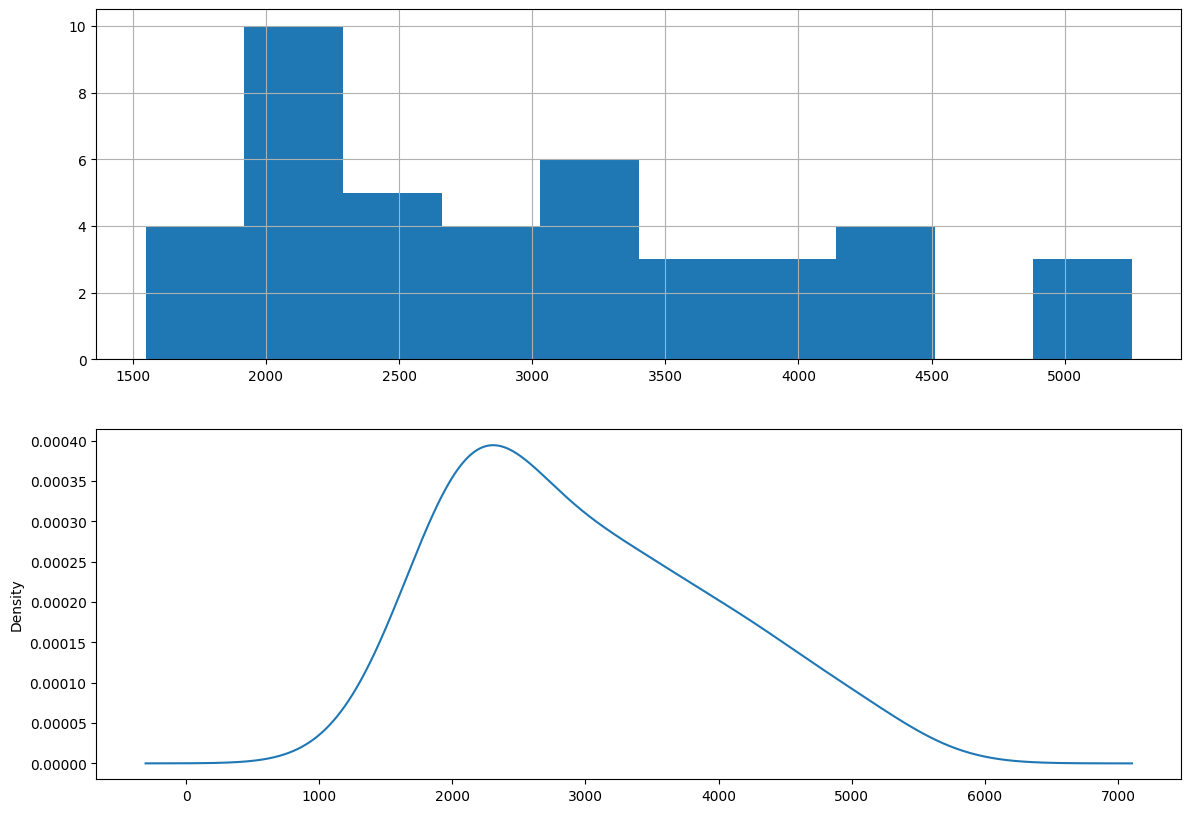

In [26]:
plt.figure(figsize=(14,10))
plt.subplot(211)
cola.Sales.hist()
plt.subplot(212)
cola.Sales.plot(kind='kde')
plt.show()


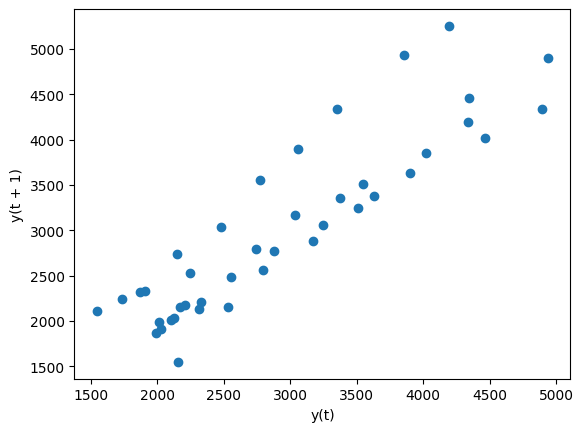

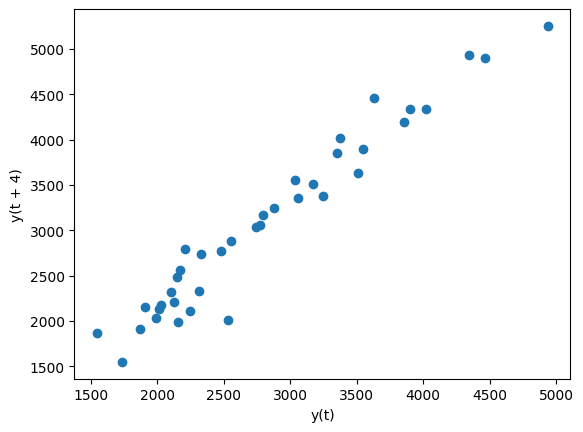

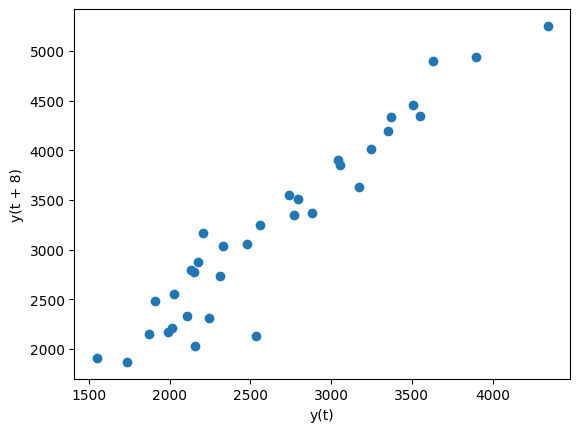

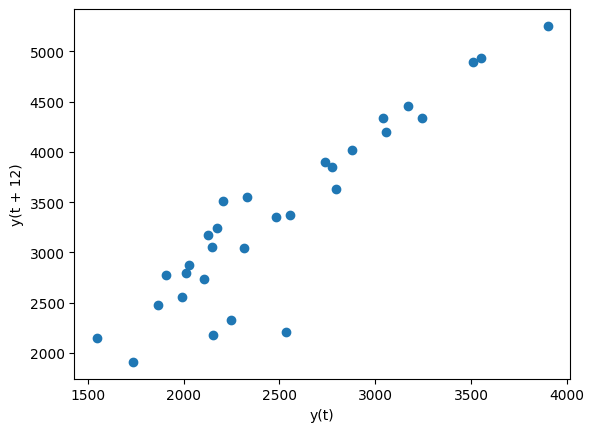

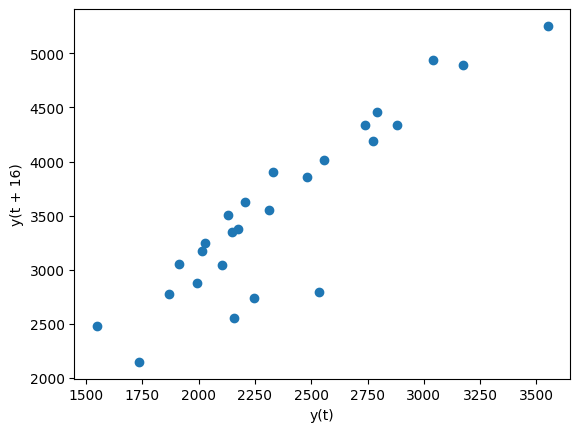

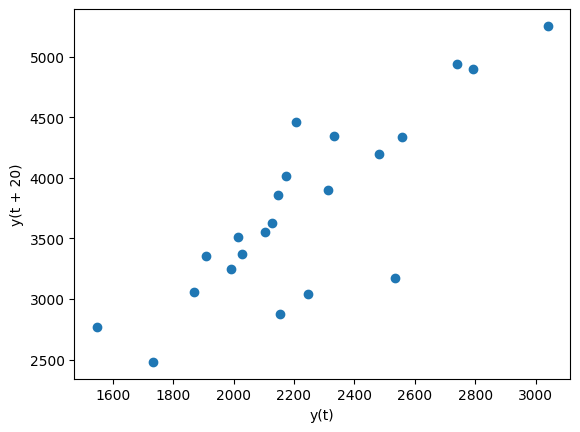

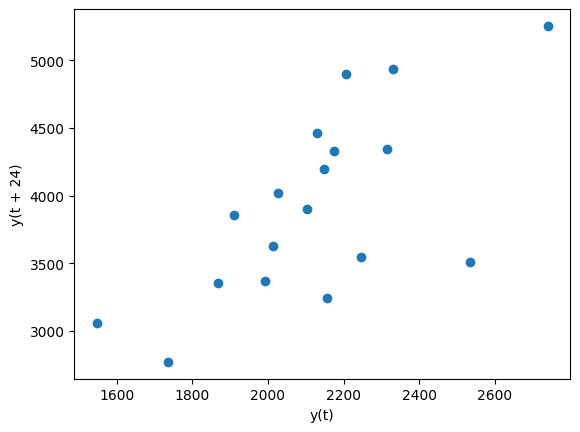

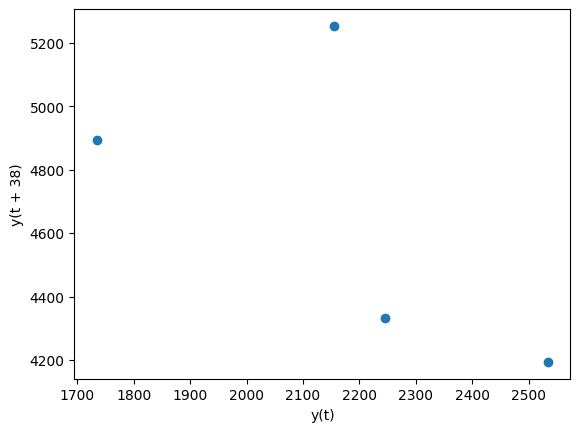

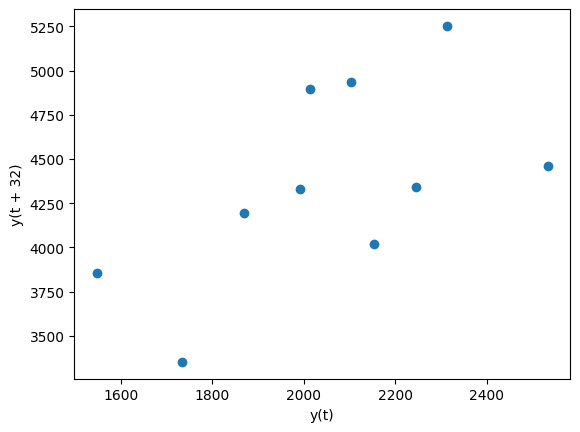

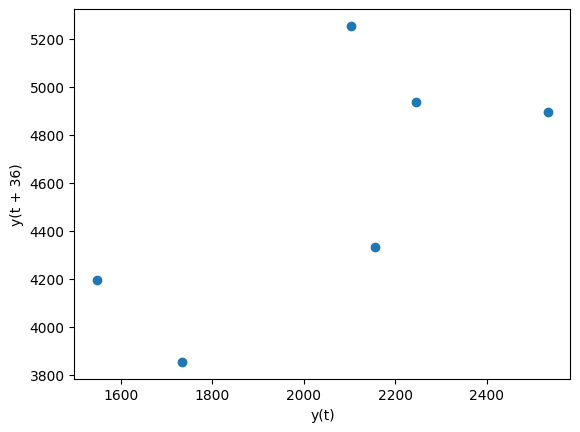

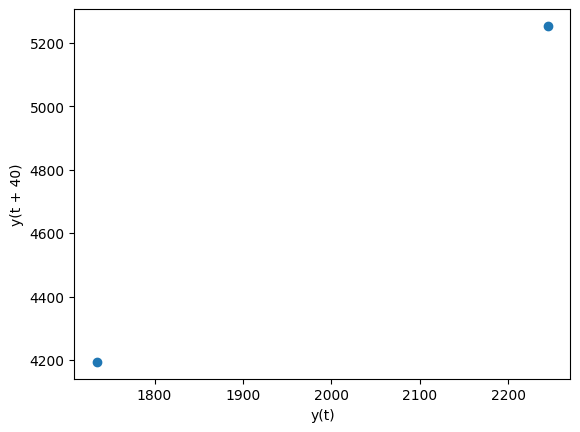

In [27]:
# create a scatter plot
for i in [1, 4, 8, 12, 16, 20, 24, 38, 32, 36, 40]:
    lag_plot(cola.Sales, lag=i)
    plt.show()

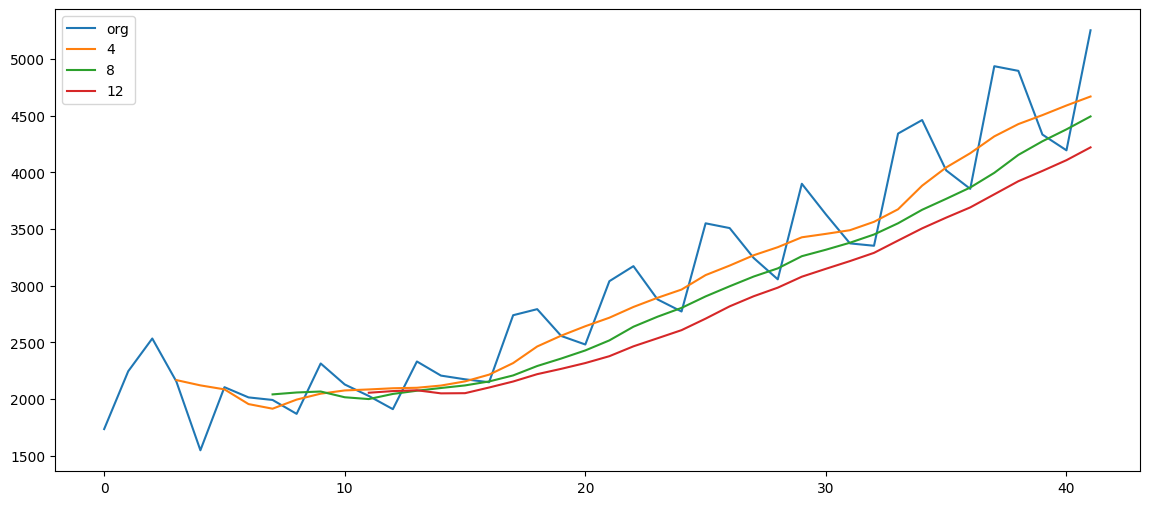

In [28]:
plt.figure(figsize=(14,6))
cola.Sales.plot(label="org")
for i in range(4,13,4):
    cola["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

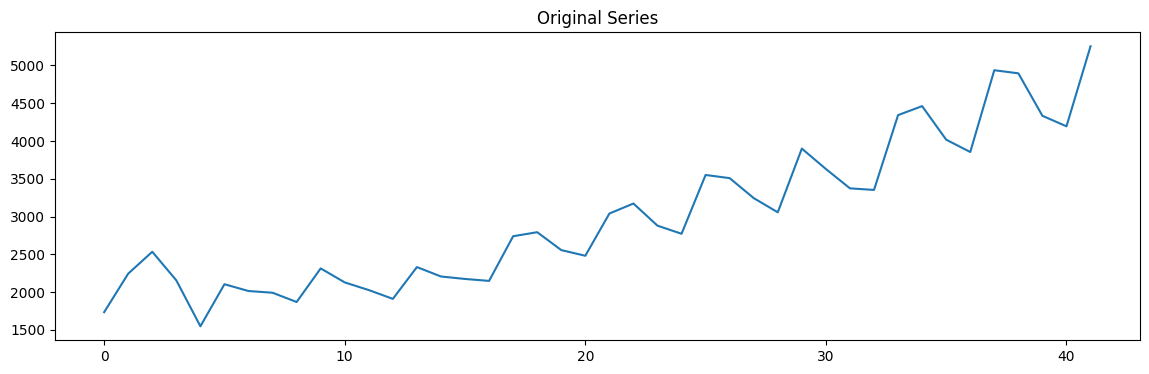

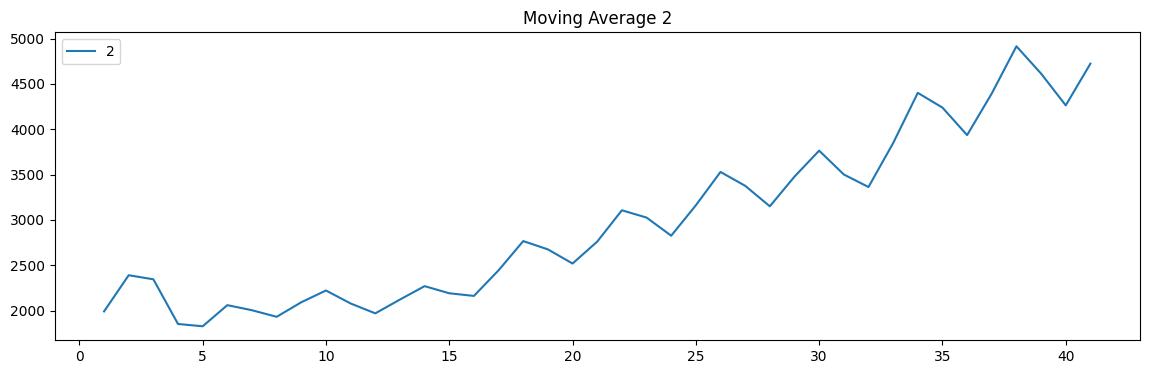

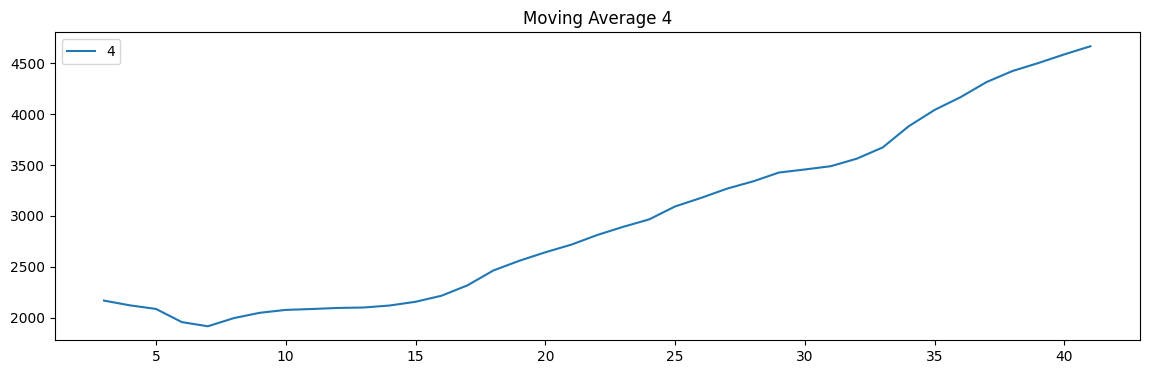

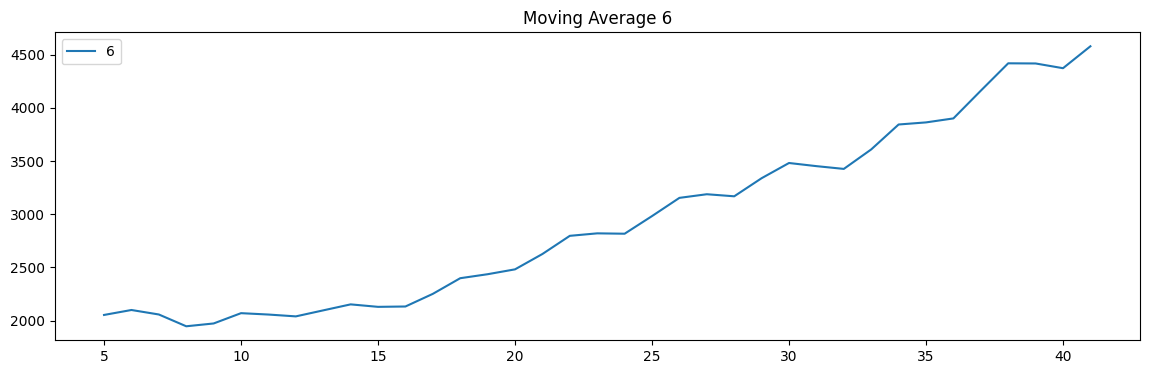

In [29]:
plt.figure(figsize=(14,4))
cola.Sales.plot(label="org")
plt.title("Original Series")
for i in range(2,7,2):
    plt.figure(figsize=(14,4))
    cola["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

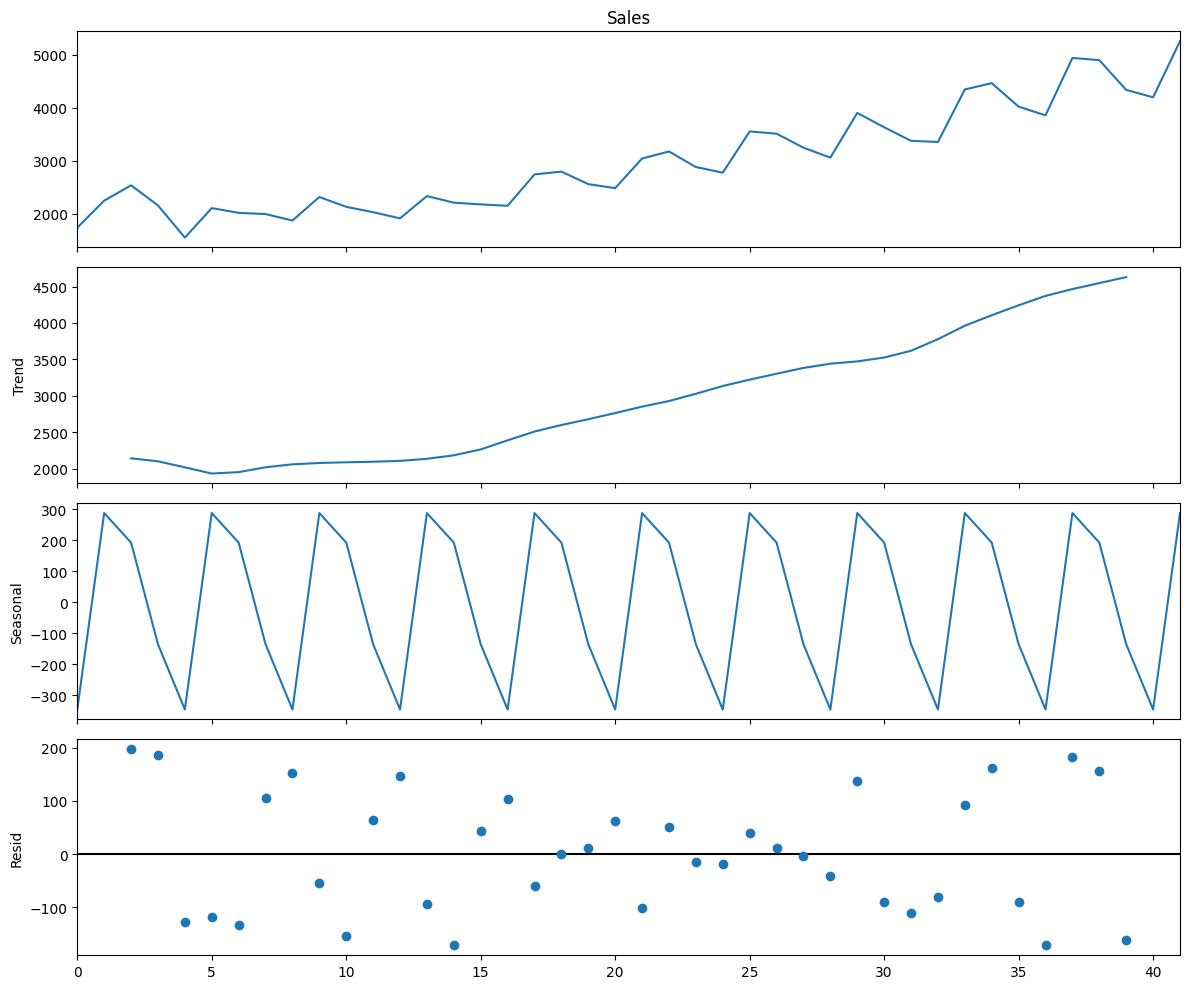

In [30]:
decompose_ts_add = seasonal_decompose(cola.Sales,period=4)
with plt.rc_context():
    plt.rc("figure", figsize=(12,10))
    decompose_ts_add.plot()
    plt.show()

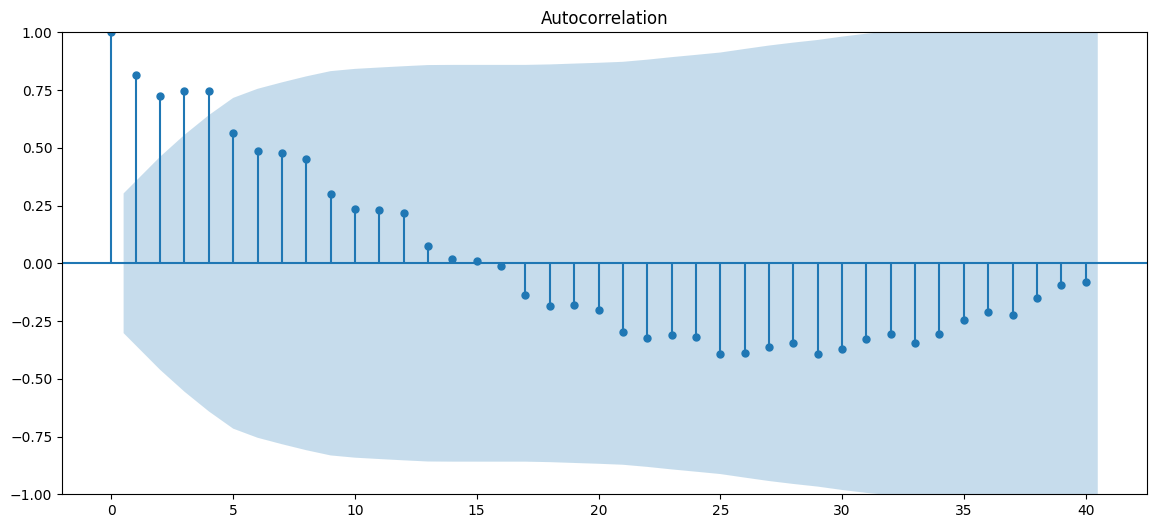

In [31]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(14,6))
    tsa_plots.plot_acf(cola.Sales,lags=40)
    plt.show()

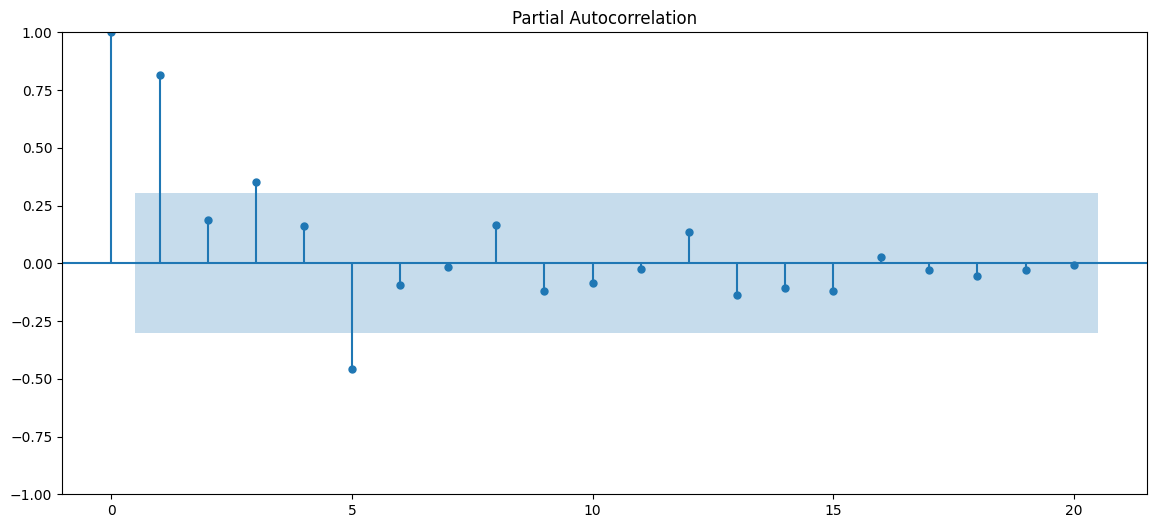

In [32]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(14,6))
    tsa_plots.plot_pacf(cola.Sales,lags=20)
    plt.show()


In [33]:
upsampled_month = cola1.drop(['Quarters','Q1','Q2','Q3','Q4'], axis=1)
upsampled_month = upsampled_month.resample('M').mean()
upsampled_month.head()

,Sales
Date,
1986-01-31,1734.827000
1986-02-28,NaN
1986-03-31,NaN
1986-04-30,2244.960999
1986-05-31,NaN


In [34]:
interpolated_month = upsampled_month.interpolate(method='linear')
interpolated_month.head()

,Sales
Date,
1986-01-31,1734.827000
1986-02-28,1904.871666
1986-03-31,2074.916332
1986-04-30,2244.960999
1986-05-31,2341.242330


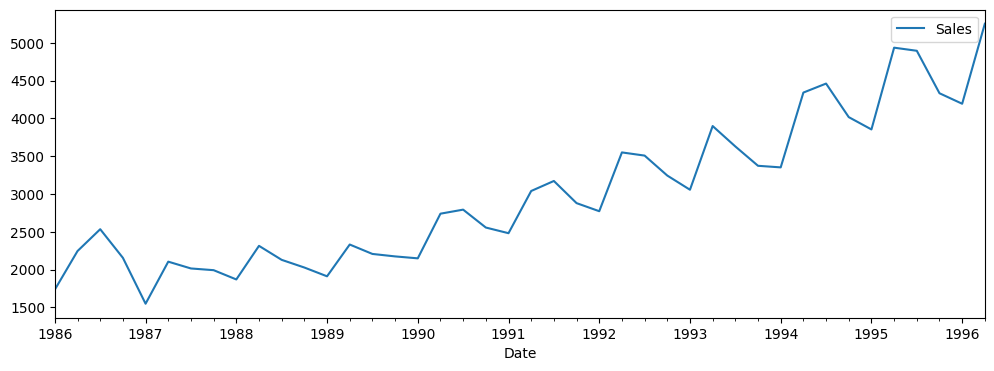

In [35]:
interpolated_month.plot(figsize=(12,4))
plt.show()

In [36]:
interpolated_month.reset_index(inplace=True)
interpolated_month['t'] = np.arange(1,len(interpolated_month)+1)
interpolated_month['t_squared'] = np.square(interpolated_month.t)
interpolated_month["month"] = interpolated_month.Date.dt.strftime("%b") # month extraction
interpolated_month["year"] = interpolated_month.Date.dt.strftime("%Y") # year extraction
months = pd.get_dummies(interpolated_month['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
df = pd.concat([interpolated_month,months],axis=1)
df['log_sales'] = np.log(df['Sales'])
df

,Date,Sales,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
0,1986-01-31,1734.827000,1,1,Jan,1986,1,0,0,0,0,0,0,0,0,0,0,0,7.458663
1,1986-02-28,1904.871666,2,4,Feb,1986,0,1,0,0,0,0,0,0,0,0,0,0,7.552170
2,1986-03-31,2074.916332,3,9,Mar,1986,0,0,1,0,0,0,0,0,0,0,0,0,7.637676
3,1986-04-30,2244.960999,4,16,Apr,1986,0,0,0,1,0,0,0,0,0,0,0,0,7.716443
4,1986-05-31,2341.242330,5,25,May,1986,0,0,0,0,1,0,0,0,0,0,0,0,7.758437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,1995-12-31,4240.333333,120,14400,Dec,1995,0,0,0,0,0,0,0,0,0,0,0,1,8.352397
120,1996-01-31,4194.000000,121,14641,Jan,1996,1,0,0,0,0,0,0,0,0,0,0,0,8.341410
121,1996-02-29,4547.000000,122,14884,Feb,1996,0,1,0,0,0,0,0,0,0,0,0,0,8.422223
122,1996-03-31,4900.000000,123,15129,Mar,1996,0,0,1,0,0,0,0,0,0,0,0,0,8.496990


In [ ]:
# Seperating into train and test

In [37]:
train = df.head(100)
test = df.tail(24)

In [ ]:
# Creating models with smf ols method

In [38]:
#Linear Model
import statsmodels.formula.api as smf

linear_model = smf.ols('Sales~t',data=train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_linear))**2))
rmse_linear

686.8740863668942

In [40]:
#Exponential Model

Exp = smf.ols('log_sales~t',data=train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

530.326802509923

In [41]:
#Quadratic

Quad = smf.ols('Sales~t+t_squared',data=train).fit()
pred_Quad = pd.Series(Quad.predict(test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

371.29418344986675

In [42]:
#Additive seasonality

add_sea = smf.ols('Sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train).fit()
pred_add_sea = pd.Series(add_sea.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1837.7879723483802

In [43]:
#Additive Seasonality Quadratic

add_sea_Quad = smf.ols('Sales~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

225.80498810355988

In [44]:
#Multiplicative Seasonality

Mul_sea = smf.ols('log_sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

1904.794417192049

In [45]:
#Multiplicative Additive Seasonality

Mul_Add_sea = smf.ols('log_sales~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea

396.4197817374411

In [46]:
#Compare the results

data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
4,rmse_add_sea_quad,225.804988
2,rmse_Quad,371.294183
6,rmse_Mult_add_sea,396.419782
1,rmse_Exp,530.326803
0,rmse_linear,686.874086
3,rmse_add_sea,1837.787972
5,rmse_Mult_sea,1904.794417


In [ ]:
# Since the additive seasonality quadratic model had the lowest rmse value, we choose this model for prediction.

In [47]:
pred_add_sea_quad

100    4239.290210
101    4253.745539
102    4268.200868
103    4226.471321
104    4184.741775
105    4143.012228
106    4114.735891
107    4086.459553
108    4062.123307
109    4299.992755
110    4537.862203
111    4775.731651
112    4782.576234
113    4802.439164
114    4822.302094
115    4785.980148
116    4749.658202
117    4713.336256
118    4690.467520
119    4667.598783
120    4648.670138
121    4891.947187
122    5135.224235
123    5378.501284
dtype: float64

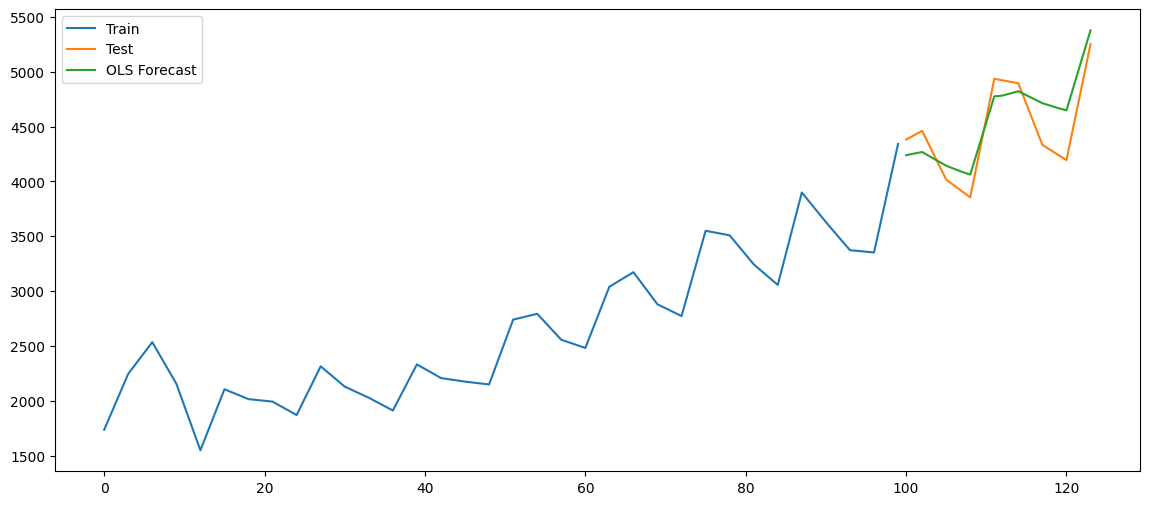

In [48]:
plt.figure(figsize=(14,6))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(pred_add_sea_quad, label='OLS Forecast')
plt.legend(loc='best')
plt.show()